In [1]:
import copy
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm 
import gym
from gym import error, spaces, utils
from gym.utils import seeding
import scipy.io
import scipy.linalg
from tqdm import tqdm

dtype = np.float32

Create class that simulates 5 roller-pair system. This system has 10 state, 1 controllable input and 2 externally measured disturbances. The system is given by 🇱

$X_{t+1} = AX_t + Bu^{control}_t + Fu^{dist}_t + w_t$

$Y_t = CX_t + v_t$

The states are given as: $X_t = [y_1 \dot{y_1} y_2 \dot{y_2} y_3 \dot{y_3} y_4 \dot{y_4} z_2  \dot{z_2}] $ where $y_i$ refers to the lateral position of the web at the $i^{th}$ roller. $z_2$ is the out-of-plane displacement of the second roller which acts as the actuating roller and the source of control. The control input $u^{control}_t$ is $\ddot{z_2}$. The external measured input is given by the position and angle of the web at roller 0.  Let the disturbances $w_t$ and $v_t$ be 0 mean and with covariance matrices $\Sigma_w$ and $Σ_v$. For ease I will assume that these two noise matrices are diagonal (uncorrelated noise) and they are parametrized by $σ_u$ and $\sigma_v$. 

The matrices A,B and F are derived using physics and have been pre-computed for a given set of system paramters (lengths between rollers, material properties of web etc). These matrices however while being derived assume constant speed and tension. However, the real system does not have constant speed and tension. To simulate this I will initialize the environment with a set of A and B matrices which have been derived for different values of speed and tension around the nominal value. To simulate the variation I will cycle through the matrices in each time-step evolution. 

I will set up the class in the following way: 

1) Use baseline LQR class from the pset as a starting point (for now still thinking in terms of full-state information) 

2) While initialising initializing I will provide the following to the class: 

a) A_mats: A_mats.shape = (vt_vars, 10, 10) where num is the number of variations of speed and tension I will use 

b) B_mats: B_mats.shape = (vt_vars, 10, 1) where num is the number of variations of speed and tension I will use

c) F_mats: F_mats.shape = (vt_vars, 10, 2) where num is the number of variations of speed and tension I will us

d) C: The observation matrix --> Different for different experiments

d) n,m: number of states and number of control knobs. These do not need to be initialized and can be obtatined from the shapes of the matrices provided. 

e) the variance values for the process and measurement noises 

f) gamma = dicount factor 

g) seed: so that experiments are repeatable

In [2]:
## Connect to Google drive !

# from google.colab import drive
# drive.mount('/content/gdrive')

# # Feel free to change the folder name
# base_folder = "/content/gdrive/MyDrive/RL_project/RL_cont_control/"

# import os
# os.chdir("/content/") # base folder on colab
# os.makedirs(base_folder, exist_ok = True)
# os.chdir(base_folder)

In [3]:
## Here I will now create a class that simulates the 5-roller pair system with variable speed and tension 

class LQEnv_flat_rollers_full_state_info (gym.Env):
  def __init__(self, A_mats, B_mats, F_mats, C, sigma_w, sigma_v, Q, R, full_state_info=True,  seed = 0, gamma = 0.9):
    """
    The LQ flat rollers evironment with full-state information, initialized with the parameters
    n: state dimension
    m: action dimension
    seed: random seed
    gamma: discount factor
    sigma: noise variance
    full_state_info: this is a boolean variable: If true then at each step we get to observe the full state and Exact associated quadratic cost 
                                                if False: then at each step we just observe the next observed sensor measurement(s) .. I will also output the true state for simulation viz. but not the cost    
    """
    np.random.seed(seed)
    self.st_vars = A_mats.shape[2] ## This is the number of matrices created for different speed and tension values
    self.n = A_mats.shape[0]
    self.m = B_mats.shape[1]
    self.m_dist = F_mats.shape[1] 

    self.action_space = spaces.Box(low = -np.inf, high = np.inf, shape =  [B_mats.shape[1],1], dtype = dtype )
    self.observation_space = spaces.Box(low = -np.inf, high = np.inf, shape =  [C.shape[0],1], dtype = dtype ) # For observation space = state space just use C = I
    
    self.full_observation_space = spaces.Box(low = -np.inf, high = np.inf, shape =  [C.shape[0]+2,1], dtype = dtype )
    
    self.A_mats = A_mats
    self.B_mats = B_mats
    self.F_mats = F_mats
    self.C = C 

    self.R =  R
    self.Q =  Q

    self.state = np.zeros((A_mats.shape[0],1)) ## Initialize to be at zero state
    self.state[0] = 0.0001 ; 
    self.state[2] = 0.0001 ; 
    self.state[4] = 0.0001 ; 
    self.state[6] = 0.0001 ; 

    self.sigma_w = sigma_w
    self.sigma_v = sigma_v
    self.gamma = gamma

    self.full_state_info = full_state_info 
    
  def step(self, action, meas_dist ,t_step):
    """
    This method is the primary interface between environment and agent.
    Paramters: 
        action: array of shape [m,1]
        meas_dist: measured input disturbance: array of shape []
        t_step: corresponds to the time-instance of the simulation we are currently in --> This will be used to decide which of the transition matrics to use at this time
                
    Returns:
        output: (next (true full) state:array, (true)cost assuming full-information : float, sensor measurement based on type and number of measurements: float,  done:bool, None)
                
    """
    err_msg = f"{action!r} ({type(action)}) invalid"
    assert self.action_space.contains(action), err_msg
    assert self.state is not None, "Call reset before using step method."
    
    w = self.sigma_w*np.random.randn(self.n,1)
    v = self.sigma_v*np.random.randn(self.C.shape[0],1)
    
    t_mod_ind = (t_step)%(self.st_vars) # This is to find out which of the variable speed/tension matrices to use

    A_curr = self.A_mats[:,:,t_mod_ind] ; 
    B_curr = self.B_mats[:,:,t_mod_ind] ; 
    F_curr = self.F_mats[:,:,t_mod_ind] ; 

    cost = (self.state.T.dot(self.Q)).dot(self.state) + (action.T.dot(self.R)).dot(action) ## This will have to change for the partially observed case
    
    #self.state = A_curr.dot(self.state) + B_curr.dot(action) + F_curr.dot(meas_dist) + w

    #print("state before step: ", self.state)

    self.state = A_curr@(self.state) + B_curr@(action) + F_curr@(meas_dist) + w

    #print("state after step: ", self.state)

    snsr_msr = self.C@(self.state) + v ;

    done = False

    return self.state, snsr_msr , cost , done, {} # Irrespective of whether I have full-state info or not I will still return the true-underlying state for simulation vizualization and 
                                                  # Depending on the kind of problem I will use the given cost (turue cost) or estimate it from the estimated state from the measurements

  def reset(self, state = None):
    """
    This method resets the environment to its initial values.
    Paramters:
        state array
            set the env to specifc state (optional)
    Returns:
        observation:    array
                        the initial state of the environment
    """
    if state is None:
        # sample from a guassian with zero mean and std of 10
        self.state = np.zeros((self.A_mats.shape[1],1)) ## Initialize to be at zero state_evolution          
        self.state[0] = 0.0001 ; 
        self.state[2] = 0.0001 ; 
        self.state[4] = 0.0001 ; 
        self.state[6] = 0.0001 ; 
    else:
        self.state = state
    return  self.state

  def close(self):
    """
    This method provides the user with the option to perform any necessary cleanup.
    """
    pass

  def sample_random_action(self):
      """
      sample actions from a normal dist with mean zero and std 10
      """
      return  10*self.action_space.sample()

def lin_policy(K):
    """
    helper function to define linear policies of the form u = L@x
    """
    def policy(state):
        return K.dot(state)
    return policy


def policy_evaluation(policy, env, ext_disturbance='sinusoid' , T = 20, N = 5):
    """
    This method evaluate the performance of a specifc policy on the env through simulating 
    it on N trajectories each of time T. Even for the partial observations case I will evaluate the policy
    in the same way. Use the 'true' costs from the environment to evaluate it. The estimated costs will be used just to develop the 
    policy.
    Paramters: 
        policy: function that takes in state and return action
        env: instant of LQEnv
        T: total time per trajectory : Sampling rate of 100Hz used
        N: number of trajectories   
        ext_disturbance: 'sinusoid' , 'step' , 'splice' --> Evaluates a given policy for the kind of input

    Returns:
        output: 
        1) mean discounted total cost 
        2) Complete *True* state-evolution for each run                 
    """

    t_range = np.linspace(0,T,(100*T+1))
    
    # Define what external disturbance to the system I am evaluating my policy for: 
    if (ext_disturbance=='sinusoid'):
      w1 = 0.02*0.25*np.sin(t_range) ;
    
    elif (ext_disturbance=='step'):
      w1 = np.zeros(t_range.shape)
      w1[t_range.shape[0]//4:3*(t_range.shape[0]//4)] = 0.02*0.25*np.ones(w1[t_range.shape[0]//4:3*(t_range.shape[0]//4)].shape)

    elif (ext_disturbance=='splice'):
      w1 = np.zeros(t_range.shape)
      w1[t_range.shape[0]//4:5*(t_range.shape[0]//16)] = 0.02*0.25*np.ones(w1[t_range.shape[0]//4:5*(t_range.shape[0]//16)].shape)


    state_evs = {} # This is a dictionary that tracks state evolution of all states for all the trajectories
    costs = []
    for ite in tqdm(range(N)):
        state = env.reset()
        gamma = env.gamma
        total_costs = 0
        state_ev = state
        for t_step in range(t_range.shape[0]): 
            t = t_range[t_step]
            action = policy(state).astype(np.float32)
            #state, obs , cost, _, _ = env.step(action)
            state, obs , cost, _, _ = env.step(action=action, meas_dist=np.atleast_2d(np.array([w1[t_step] , 0])).T, t_step=t_step)
            
            total_costs += cost * gamma**(t)            
            state_ev = np.concatenate((state_ev, state), axis=1)
            
        costs.append(total_costs)
        state_evs[ite] = state_ev
    return np.mean(costs)    



In [4]:
## Later transfer web-visualization code here so I can see what the hell is going on!!

In [5]:
## Read in transition matrices derived from physics
var_mods = scipy.io.loadmat('data_folder/var_models.mat')

In [6]:
from gym.core import Env

A_mats = var_mods['A_mats'] 
B_mats = var_mods['B_mats'][:,:1,:]
F_mats = var_mods['B_mats'][:,1:,:]

env = LQEnv_flat_rollers_full_state_info(A_mats=A_mats, B_mats=B_mats, F_mats=F_mats, C=np.identity(10), sigma_w=1e-6 , sigma_v=1e-6, Q=np.identity(10), R=np.identity(1))

In [7]:
## Simulate system without any external input and plot state-evolution just to see 
## if it works

t_range = np.linspace(0,20,2001) 

w1 = 0.02*0.25*np.sin(t_range) ; 
env.reset()
state_evolution = env.state ; 

for t_step in range(t_range.shape[0]):     
#for t_step in range(1):   
    t = t_range[t_step]
    #print("time = ", t)
    action = np.atleast_2d(np.array([0])).astype(np.float32) ; 
    state, obs , cost, _, _ = env.step(action=action, meas_dist=np.atleast_2d(np.array([w1[t_step] , 0])).T, t_step=t_step)
    #total_costs += cost * gamma**(t)

    state_evolution = np.concatenate((state_evolution, state), axis=1)

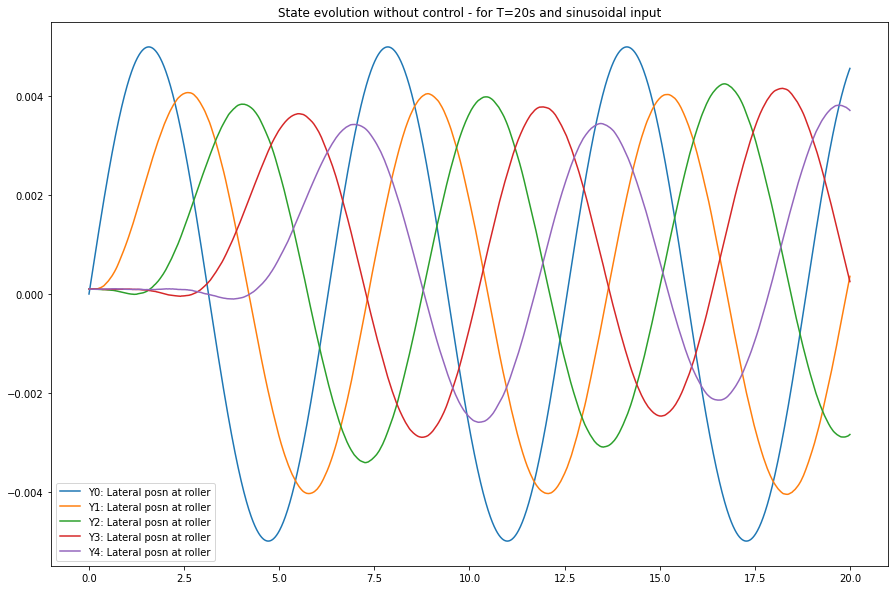

In [8]:
plt.figure(figsize=(15,10))
plt.title("State evolution without control - for T=20s and sinusoidal input")

plt.plot(t_range, w1, label='Y0: Lateral posn at roller')
plt.plot(t_range, state_evolution[0,:2001], label='Y1: Lateral posn at roller')
plt.plot(t_range, state_evolution[2,:2001], label='Y2: Lateral posn at roller')
plt.plot(t_range, state_evolution[4,:2001], label='Y3: Lateral posn at roller')
plt.plot(t_range, state_evolution[6,:2001], label='Y4: Lateral posn at roller')

plt.legend() ; 

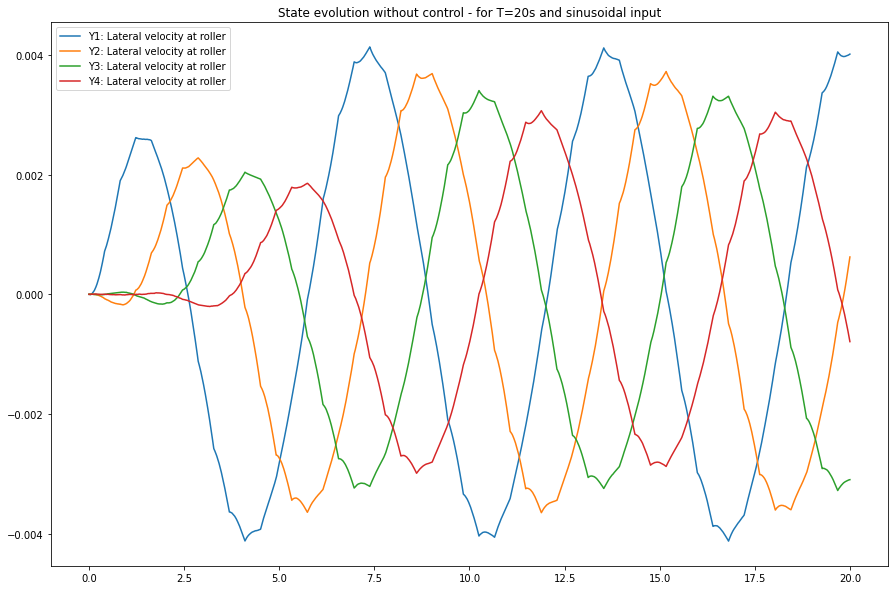

In [9]:
plt.figure(figsize=(15,10))
plt.title("State evolution without control - for T=20s and sinusoidal input")

plt.plot(t_range, state_evolution[1,:2001], label='Y1: Lateral velocity at roller')
plt.plot(t_range, state_evolution[3,:2001], label='Y2: Lateral velocity at roller')
plt.plot(t_range, state_evolution[5,:2001], label='Y3: Lateral velocity at roller')
plt.plot(t_range, state_evolution[7,:2001], label='Y4: Lateral velocity at roller')

plt.legend() ;

2 things I need to do today are:- 

1) Code up ELQR solution assuming full-state information
2) Set up simple Kalman filtering for optimal state-estimation 

These will serve as the baselines for my work

What will be the RL strategies that I will use?? 

1) Memory-based control with RNNs --> This uses policy gradient methods!!

2) ALso try simple Q-learning as we have done in class!


## Extended LQR 

The regular LQR is developed for a state-space model of the form below where there is no external measured disturbance to the system

$X_{t+1} = AX_t + Bu_t$

However, the state-space form that I am working with for this problem is one for which there is also a measured disturbance coming into the system and is of the form:

$X_{t+1} = AX_t + Bu^{control}_t + Fu^{dist}_t$

So, the LQR fomulation needs to be slightly re-worked as in 

https://www.sciencedirect.com/science/article/pii/S000510981630406X


For this --> develop control strategy assuming constant speed and tension model! Using nominal values of speed and tensi on (8 and 87.5)

The simulation however is still with variable speed and tension


In [10]:
## Implement the ELQR optimal control strategy

#Read in nominal matrix values

rp5_sys_disc = scipy.io.loadmat('data_folder/flat_web_ss_disc.mat')

A_nom = rp5_sys_disc['A']
B_nom = rp5_sys_disc['B'][:,:1]
F_nom = rp5_sys_disc['B'][:,1:]

env = LQEnv_flat_rollers_full_state_info(A_mats=A_mats, B_mats=B_mats, F_mats=F_mats, C=np.identity(10), sigma_w=1e-6 , sigma_v=1e-6, Q=np.identity(10), R=np.identity(1))

def gen_ELQR_mats(A,B,F,env):

    '''
    This function computes the relevant gain matrix for the ELQR formulation 
    Input: A,B,F --> These are the nominal system matrix values assumed 
        env: The LQ environment for which we are trying to solve the problem --> giet Q,R and gamma through this 

    Output: K: Gain matrix such that we use -Kx 
          G: Additional gain matrix for the measured disturbances we use -G*meas_dist
          u_cont = -(Kx + G*meas_dist)
    '''

    A = A*np.sqrt(env.gamma)
    B = B
    F = F
    Q = env.Q
    R = env.R*(1/env.gamma)

    P = scipy.linalg.solve_discrete_are(a=A, b=B, q=Q, r=R)
    K = (np.linalg.inv((R + B.T@P@B)))@(B.T)@P@(A)

    S = np.linalg.inv(A@np.linalg.inv(P-Q)-np.linalg.inv(P))@F

    G = K@np.linalg.inv(A-np.linalg.inv(P)@(P-Q))@F

    return K, G

In [11]:
K,G = gen_ELQR_mats(A=A_nom, B=B_nom, F=F_nom, env=env)

In [12]:
## Simulate system withELQR control
## if it works

Q = np.identity(10) ; 
Q[2,2] = 100 ; 
Q[4,4] = 10000

# Q[0,0] = 0 ; 
# Q[1,1] = 0 ; 
# Q[2,2] = 0 ; 
# Q[3,3] = 0 ; 
# Q[5,5] = 0 ; 
# Q[7,7] = 0 ; 
# Q[8,8] = 0 ; 
# Q[9,9] = 0 ; 



env = LQEnv_flat_rollers_full_state_info(A_mats=A_mats, B_mats=B_mats, F_mats=F_mats, C=np.identity(10), sigma_w=1e-6 , sigma_v=1e-6, Q=Q, R=np.identity(1))
K,G = gen_ELQR_mats(A=A_nom, B=B_nom, F=F_nom, env=env)

#t_range = np.linspace(0,20,2001) 

t_range = np.linspace(0,40,4001) 

w1 = 0.02*0.25*np.sin(t_range) ; 
env.reset()
state_evolution = env.state ; 

for t_step in range(t_range.shape[0]):     
#for t_step in range(1):   
    t = t_range[t_step]
    #print("time = ", t)

    meas_dist = np.atleast_2d(np.array([w1[t_step] , 0])).T
    ut = -(K@state + G@meas_dist)

    action = np.atleast_2d(ut).astype(np.float32) ; 
    state, obs , cost, _, _ = env.step(action=action, meas_dist=np.atleast_2d(np.array([w1[t_step] , 0])).T, t_step=t_step)
    #total_costs += cost * gamma**(t)

    state_evolution = np.concatenate((state_evolution, state), axis=1)

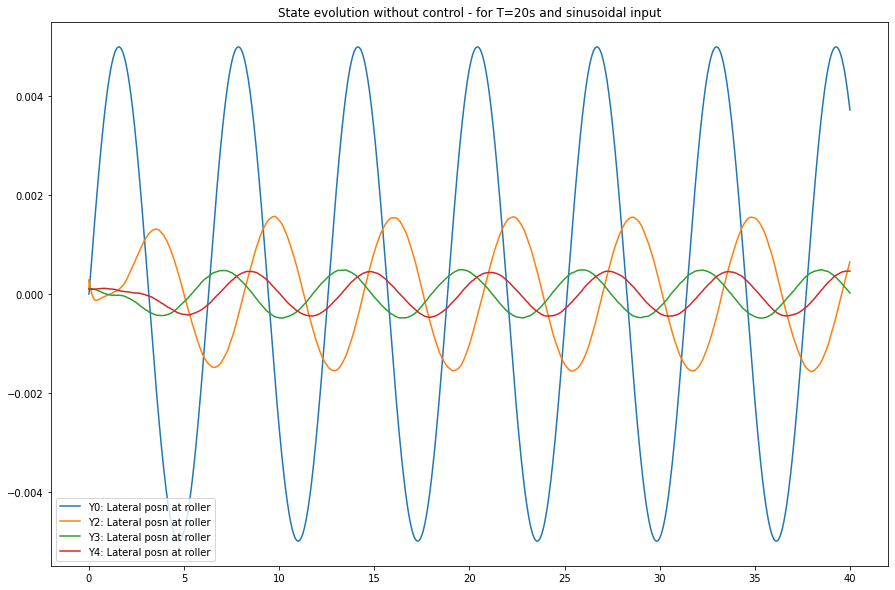

In [13]:
plt.figure(figsize=(15,10))
plt.title("State evolution without control - for T=20s and sinusoidal input")

plt.plot(t_range, w1, label='Y0: Lateral posn at roller')
#plt.plot(t_range, state_evolution[0,:2001], label='Y1: Lateral posn at roller')
plt.plot(t_range, state_evolution[2,:4001], label='Y2: Lateral posn at roller')
plt.plot(t_range, state_evolution[4,:4001], label='Y3: Lateral posn at roller')
plt.plot(t_range, state_evolution[6,:4001], label='Y4: Lateral posn at roller')

plt.legend() ;

## State Estimation - 

For partially observed case --> Will use standard Kalman filter at each step and then apply ELQR on best state estimate

## Memory-based control with Recurrent Neural networks

Using the idea of applying Recurrent DPG and recurrent SVG algorithms to this problem. These algorithms are deterministic and stochastic versions of the same idea. Key idea of the algorithm is that it is a n actor-critic approach of policy gradient methods. A key element is that it has been developed specifically for solving POMDPs. The idea is that it uses recurrent networks so it learns to preserve some memory of the observations, actions. This would be helpful for internally doing good state-estimation internally

I will be using the code from the following repository as a starting point

https://github.com/fshamshirdar/pytorch-rdpg

The paper referenced is the following

https://arxiv.org/abs/1512.04455

The way I will transfer the code is the following (mostly for readability). I will use one cell to define the classes and functions in each script. The ordering is based on reading the code and figuring out which scripts come first (ordering chart is in my notes)

In [14]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
from torch.distributions import Categorical
from collections import namedtuple

import matplotlib.pyplot as plt
from matplotlib import animation

import copy

import argparse
from gym import spaces

In [15]:
# from common.buffers import *
# from common.value_networks import *
# from common.policy_networks import *
# from common.utils import *

## buffers.py

In [16]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = int((self.position + 1) % self.capacity)  # as a ring buffer

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack,
                                                      zip(*batch))  # stack for each element
        ''' 
        the * serves as unpack: sum(a,b) <=> batch=(a,b), sum(*batch) ;
        zip: a=[1,2], b=[2,3], zip(a,b) => [(1, 2), (2, 3)] ;
        the map serves as mapping the function on each list element: map(square, [2,3]) => [4,9] ;
        np.stack((1,2)) => array([1, 2])
        '''
        return state, action, reward, next_state, done

    def __len__(
            self):  # cannot work in multiprocessing case, len(replay_buffer) is not available in proxy of manager!
        return len(self.buffer)

    def get_length(self):
        return len(self.buffer)

class ReplayBufferPER:
    """ 
    Replay buffer with Prioritized Experience Replay (PER),
    TD error as sampling weights. This is a simple version without sumtree.
    Reference:
    https://github.com/Felhof/DiscreteSAC/blob/main/utilities/ReplayBuffer.py
    """
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
        self.weights = np.zeros(int(capacity))
        self.max_weight = 10**-2
        self.delta = 10**-4

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.weights[self.position] = self.max_weight  # new sample has max weights

        self.position = int((self.position + 1) % self.capacity)  # as a ring buffer

    def sample(self, batch_size):
        set_weights = self.weights[:self.position] + self.delta
        probabilities = set_weights / sum(set_weights)
        self.indices = np.random.choice(range(self.position), batch_size, p=probabilities, replace=False)
        batch = np.array(self.buffer)[list(self.indices)]
        state, action, reward, next_state, done = map(np.stack,
                                                      zip(*batch))  # stack for each element
        ''' 
        the * serves as unpack: sum(a,b) <=> batch=(a,b), sum(*batch) ;
        zip: a=[1,2], b=[2,3], zip(a,b) => [(1, 2), (2, 3)] ;
        the map serves as mapping the function on each list element: map(square, [2,3]) => [4,9] ;
        np.stack((1,2)) => array([1, 2])
        '''
        return state, action, reward, next_state, done

    def update_weights(self, prediction_errors):
        max_error = max(prediction_errors)
        self.max_weight = max(self.max_weight, max_error)
        self.weights[self.indices] = prediction_errors

    def __len__(
            self):  # this is a stupid func! cannot work in multiprocessing case, len(replay_buffer) is not available in proxy of manager!
        return len(self.buffer)

    def get_length(self):
        return len(self.buffer)

class ReplayBufferLSTM:
    """ 
    Replay buffer for agent with LSTM network additionally using previous action, can be used 
    if the hidden states are not stored (arbitrary initialization of lstm for training).
    And each sample contains the whole episode instead of a single step.
    """
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, last_action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, last_action, reward, next_state, done)
        self.position = int((self.position + 1) % self.capacity)  # as a ring buffer

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, last_action, reward, next_state, done = map(np.stack,
                                                      zip(*batch))  # stack for each element
        ''' 
        the * serves as unpack: sum(a,b) <=> batch=(a,b), sum(*batch) ;
        zip: a=[1,2], b=[2,3], zip(a,b) => [(1, 2), (2, 3)] ;
        the map serves as mapping the function on each list element: map(square, [2,3]) => [4,9] ;
        np.stack((1,2)) => array([1, 2])
        '''
        return state, action, last_action, reward, next_state, done

    def __len__(
            self):  # cannot work in multiprocessing case, len(replay_buffer) is not available in proxy of manager!
        return len(self.buffer)

    def get_length(self):
        return len(self.buffer)

class ReplayBufferLSTM2:
    """ 
    Replay buffer for agent with LSTM network additionally storing previous action, 
    initial input hidden state and output hidden state of LSTM.
    And each sample contains the whole episode instead of a single step.
    'hidden_in' and 'hidden_out' are only the initial hidden state for each episode, for LSTM initialization.
    """
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, hidden_in, hidden_out, state, action, last_action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (hidden_in, hidden_out, state, action, last_action, reward, next_state, done)
        self.position = int((self.position + 1) % self.capacity)  # as a ring buffer

    def sample(self, batch_size):
        s_lst, a_lst, la_lst, r_lst, ns_lst, hi_lst, ci_lst, ho_lst, co_lst, d_lst=[],[],[],[],[],[],[],[],[],[]
        batch = random.sample(self.buffer, batch_size)
        for sample in batch:
            (h_in, c_in), (h_out, c_out), state, action, last_action, reward, next_state, done = sample
            s_lst.append(state) 
            a_lst.append(action)
            la_lst.append(last_action)
            r_lst.append(reward)
            ns_lst.append(next_state)
            d_lst.append(done)
            hi_lst.append(h_in)  # h_in: (1, batch_size=1, hidden_size)
            ci_lst.append(c_in)
            ho_lst.append(h_out)
            co_lst.append(c_out)
        hi_lst = torch.cat(hi_lst, dim=-2).detach() # cat along the batch dim
        ho_lst = torch.cat(ho_lst, dim=-2).detach()
        ci_lst = torch.cat(ci_lst, dim=-2).detach()
        co_lst = torch.cat(co_lst, dim=-2).detach()

        hidden_in = (hi_lst, ci_lst)
        hidden_out = (ho_lst, co_lst)

        return hidden_in, hidden_out, s_lst, a_lst, la_lst, r_lst, ns_lst, d_lst

    def __len__(
            self):  # cannot work in multiprocessing case, len(replay_buffer) is not available in proxy of manager!
        return len(self.buffer)

    def get_length(self):
        return len(self.buffer)


class ReplayBufferGRU:
    """ 
    Replay buffer for agent with GRU network additionally storing previous action, 
    initial input hidden state and output hidden state of GRU.
    And each sample contains the whole episode instead of a single step.
    'hidden_in' and 'hidden_out' are only the initial hidden state for each episode, for GRU initialization.
    """
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, hidden_in, hidden_out, state, action, last_action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (hidden_in, hidden_out, state, action, last_action, reward, next_state, done)
        self.position = int((self.position + 1) % self.capacity)  # as a ring buffer

    def sample(self, batch_size):
        s_lst, a_lst, la_lst, r_lst, ns_lst, hi_lst, ho_lst, d_lst=[],[],[],[],[],[],[],[]
        batch = random.sample(self.buffer, batch_size)
        for sample in batch:
            h_in, h_out, state, action, last_action, reward, next_state, done = sample
            s_lst.append(state) 
            a_lst.append(action)
            la_lst.append(last_action)
            r_lst.append(reward)
            ns_lst.append(next_state)
            d_lst.append(done)
            hi_lst.append(h_in)  # h_in: (1, batch_size=1, hidden_size)
            ho_lst.append(h_out)
        hi_lst = torch.cat(hi_lst, dim=-2).detach() # cat along the batch dim
        ho_lst = torch.cat(ho_lst, dim=-2).detach()

        return hi_lst, ho_lst, s_lst, a_lst, la_lst, r_lst, ns_lst, d_lst

    def __len__(
            self):  # cannot work in multiprocessing case, len(replay_buffer) is not available in proxy of manager!
        return len(self.buffer)

    def get_length(self):
        return len(self.buffer)

## initialize.py

In [17]:
def linear_weights_init(m):
    if isinstance(m, nn.Linear):
        stdv = 1. / math.sqrt(m.weight.size(1))
        m.weight.data.uniform_(-stdv, stdv)
        if m.bias is not None:
            m.bias.data.uniform_(-stdv, stdv)


def conv_weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight.data)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

## value_networks.py

In [19]:
class ValueNetworkBase(nn.Module):
    """ Base network class for value function approximation """
    def __init__(self, state_space, activation):
        super(ValueNetworkBase, self).__init__()
        self._state_space = state_space
        self._state_shape = state_space.shape
        if len(self._state_shape) == 1:
            self._state_dim = self._state_shape[0]
        else:  # high-dim state
            pass  

        self.activation = activation

    def forward(self):
        pass

class QNetworkBase(ValueNetworkBase):
    def __init__(self, state_space, action_space, activation ):
        super().__init__( state_space, activation)
        self._action_space = action_space
        self._action_shape = action_space.shape
        self._action_dim = self._action_shape[0]


class ValueNetwork(ValueNetworkBase):
    def __init__(self, state_space, hidden_dim, activation=F.relu, output_activation=None):
        super().__init__(state_space, activation)

        self.linear1 = nn.Linear(self._state_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, hidden_dim)
        self.linear4 = nn.Linear(hidden_dim, 1)
        # weights initialization
        self.linear4.apply(linear_weights_init)
        
    def forward(self, state):
        x = self.activation(self.linear1(state))
        x = self.activation(self.linear2(x))
        x = self.activation(self.linear3(x))
        x = self.linear4(x)
        return x        


class QNetwork(QNetworkBase):
    def __init__(self, state_space, action_space, hidden_dim, activation=F.relu, output_activation=None):
        super().__init__(state_space, action_space, activation)

        #self.linear1 = nn.Linear(self._state_dim+self._action_dim, hidden_dim)
        self.linear1 = nn.Linear(state_space.shape[0]+action_space.shape[0], hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, hidden_dim)
        self.linear4 = nn.Linear(hidden_dim, 1)
        # weights initialization
        self.linear4.apply(linear_weights_init)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1) # the dim 0 is number of samples
        x = self.activation(self.linear1(x))
        x = self.activation(self.linear2(x))
        x = self.activation(self.linear3(x))
        x = self.linear4(x)
        return x        

class QNetworkLSTM(QNetworkBase):
    """
    Q network with LSTM structure.
    The network follows two-branch structure as in paper: 
    Sim-to-Real Transfer of Robotic Control with Dynamics Randomization
    """
    def __init__(self, state_space, action_space, hidden_dim, activation=F.relu, output_activation=None):
        super().__init__(state_space, action_space, activation)
        self.hidden_dim = hidden_dim

        #self.linear1 = nn.Linear(self._state_dim+self._action_dim, hidden_dim)
        #self.linear2 = nn.Linear(self._state_dim+self._action_dim, hidden_dim)        

        self.linear1 = nn.Linear(state_space.shape[0]+action_space.shape[0], hidden_dim)           
        self.linear2 = nn.Linear(state_space.shape[0]+action_space.shape[0], hidden_dim)
        
        self.lstm1 = nn.LSTM(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(2*hidden_dim, hidden_dim)
        self.linear4 = nn.Linear(hidden_dim, 1)
        # weights initialization
        self.linear4.apply(linear_weights_init)
        
    def forward(self, state, action, last_action, hidden_in):
        """ 
        state shape: (batch_size, sequence_length, state_dim)
        output shape: (batch_size, sequence_length, 1)
        for lstm needs to be permuted as: (sequence_length, batch_size, state_dim)
        """
        state = state.permute(1,0,2)
        action = action.permute(1,0,2)
        last_action = last_action.permute(1,0,2)
        # branch 1
        fc_branch = torch.cat([state, action], -1) 
        fc_branch = self.activation(self.linear1(fc_branch))
        # branch 2
        lstm_branch = torch.cat([state, last_action], -1) 
        lstm_branch = self.activation(self.linear2(lstm_branch))  # linear layer for 3d input only applied on the last dim
        lstm_branch, lstm_hidden = self.lstm1(lstm_branch, hidden_in)  # no activation after lstm
        # merged
        merged_branch=torch.cat([fc_branch, lstm_branch], -1) 

        x = self.activation(self.linear3(merged_branch))
        x = self.linear4(x)
        x = x.permute(1,0,2)  # back to same axes as input    
        return x, lstm_hidden    # lstm_hidden is actually tuple: (hidden, cell)   

class QNetworkLSTM2(QNetworkBase):
    """
    Q network with LSTM structure.
    The network follows single-branch structure as in paper: 
    Memory-based control with recurrent neural networks
    """
    def __init__(self, state_space, action_space, hidden_dim, activation=F.relu, output_activation=None):
        super().__init__(state_space, action_space, activation)
        self.hidden_dim = hidden_dim

        #self.linear1 = nn.Linear(self._state_dim+2*self._action_dim, hidden_dim)        
        
        self.linear1 = nn.Linear(state_space.shape[0]+2*action_space.shape[0], hidden_dim)
        self.lstm1 = nn.LSTM(hidden_dim, hidden_dim)        
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)        
        self.linear3 = nn.Linear(hidden_dim, 1)
        # weights initialization
        self.linear3.apply(linear_weights_init)
        
    def forward(self, state, action, last_action, hidden_in):
        """ 
        state shape: (batch_size, sequence_length, state_dim)
        output shape: (batch_size, sequence_length, 1)
        for lstm needs to be permuted as: (sequence_length, batch_size, state_dim)
        """
        state = state.permute(1,0,2)
        action = action.permute(1,0,2)
        last_action = last_action.permute(1,0,2)
        # single branch
        x = torch.cat([state, action, last_action], -1) 
        x = self.activation(self.linear1(x))        
        x, lstm_hidden = self.lstm1(x, hidden_in)  # no activation after lstm
        x = self.activation(self.linear2(x))        
        x = self.linear3(x)
        x = x.permute(1,0,2)  # back to same axes as input    
        return x, lstm_hidden    # lstm_hidden is actually tuple: (hidden, cell)   
    
    


class QNetworkGRU(QNetworkBase):
    def __init__(self, state_space, action_space, hidden_dim, activation=F.relu, output_activation=None):
        super().__init__(state_space, action_space, activation)
        self.hidden_dim = hidden_dim

        self.linear1 = nn.Linear(self._state_dim+self._action_dim, hidden_dim)
        self.linear2 = nn.Linear(self._state_dim+self._action_dim, hidden_dim)
        self.lstm1 = nn.GRU(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(2*hidden_dim, hidden_dim)
        self.linear4 = nn.Linear(hidden_dim, 1)
        # weights initialization
        self.linear4.apply(linear_weights_init)
        
    def forward(self, state, action, last_action, hidden_in):
        """ 
        state shape: (batch_size, sequence_length, state_dim)
        output shape: (batch_size, sequence_length, 1)
        for lstm needs to be permuted as: (sequence_length, batch_size, state_dim)
        """
        state = state.permute(1,0,2)
        action = action.permute(1,0,2)
        last_action = last_action.permute(1,0,2)
        # branch 1
        fc_branch = torch.cat([state, action], -1) 
        fc_branch = self.activation(self.linear1(fc_branch))
        # branch 2
        lstm_branch = torch.cat([state, last_action], -1) 
        lstm_branch = self.activation(self.linear2(lstm_branch))  # linear layer for 3d input only applied on the last dim
        lstm_branch, lstm_hidden = self.lstm1(lstm_branch, hidden_in)  # no activation after lstm
        # merged
        merged_branch=torch.cat([fc_branch, lstm_branch], -1) 

        x = self.activation(self.linear3(merged_branch))
        x = self.linear4(x)
        x = x.permute(1,0,2)  # back to same axes as input    
        return x, lstm_hidden    # lstm_hidden is actually tuple: (hidden, cell) 

## policy_networks.py

In [20]:
class PolicyNetworkBase(nn.Module):
    """ Base network class for policy function """
    def __init__(self, state_space, action_space, action_range):
        super(PolicyNetworkBase, self).__init__()
        self._state_space = state_space
        self._state_shape = state_space.shape
        if len(self._state_shape) == 1:
            self._state_dim = self._state_shape[0]
        else:  # high-dim state
            pass  
        self._action_space = action_space
        self._action_shape = action_space.shape
        if len(self._action_shape) < 1:  # Discrete space
            self._action_dim = action_space.n
        else:
            self._action_dim = self._action_shape[0]
        self.action_range = action_range

    def forward(self):
        pass
    
    def evaluate(self):
        pass 
    
    def get_action(self):
        pass

    def sample_action(self,):
        a=torch.FloatTensor(self._action_dim).uniform_(-1, 1)
        return self.action_range*a.numpy()

class DPG_PolicyNetwork(PolicyNetworkBase):
    """
    Deterministic policy gradient network
    """
    def __init__(self, state_space, action_space, hidden_dim, action_range=1., init_w=3e-3):
        super().__init__(state_space, action_space, action_range)
        
        #self.linear1 = nn.Linear(self._state_dim, hidden_dim)
        self.linear1 = nn.Linear(state_space.shape[0], hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, self._action_dim) # output dim = dim of action

        # weights initialization
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
    

    def forward(self, state):
        activation=F.relu
        x = activation(self.linear1(state)) 
        x = activation(self.linear2(x))
        x = F.tanh(self.linear3(x)).clone() # need clone to prevent in-place operation (which cause gradients not be drived)
        # x = self.linear3(x) # for simplicity, no restriction on action range

        return x

    def evaluate(self, state, noise_scale=0.0):
        '''
        evaluate action within GPU graph, for gradients flowing through it, noise_scale controllable
        '''
        normal = Normal(0, 1)
        action = self.forward(state)
        #noise = noise_scale * normal.sample(action.shape).cuda()
        noise = noise_scale * normal.sample(action.shape).to(device)
        action = self.action_range*action+noise
        return action


    def get_action(self, state, noise_scale=1.0):
        '''
        select action for sampling, no gradients flow, noisy action, return .cpu
        '''
        #state = torch.FloatTensor(state).unsqueeze(0).cuda() # state dim: (N, dim of state)
        state = torch.FloatTensor(state).unsqueeze(0).to(device) # state dim: (N, dim of state)
        normal = Normal(0, 1)
        action = self.forward(state)
        # noise = noise_scale * normal.sample(action.shape).cuda()
        noise = noise_scale * normal.sample(action.shape).to(device)
        action=self.action_range*action + noise
        return action.detach().cpu().numpy()[0]

    def sample_action(self):
        normal = Normal(0, 1)
        random_action=self.action_range*normal.sample( (self._action_dim,) )

        return random_action.cpu().numpy()

class DPG_PolicyNetworkLSTM(PolicyNetworkBase):
    """
    Deterministic policy gradient network with LSTM structure.
    The network follows two-branch structure as in paper: 
    Sim-to-Real Transfer of Robotic Control with Dynamics Randomization
    """
    def __init__(self, state_space, action_space, hidden_dim, action_range=1., init_w=3e-3):
        super().__init__(state_space, action_space, action_range)
        self.hidden_dim = hidden_dim

        # self.linear1 = nn.Linear(self._state_dim, hidden_dim)
        # self.linear2 = nn.Linear(self._state_dim+self._action_dim, hidden_dim)
        
        self.linear1 = nn.Linear(state_space.shape[0], hidden_dim)
        self.linear2 = nn.Linear(state_space.shape[0]+action_space.shape[0], hidden_dim)        
        
        self.lstm1 = nn.LSTM(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(2*hidden_dim, hidden_dim)
        self.linear4 = nn.Linear(hidden_dim, self._action_dim) # output dim = dim of action

        # weights initialization
        self.linear4.weight.data.uniform_(-init_w, init_w)
        self.linear4.bias.data.uniform_(-init_w, init_w)
    

    def forward(self, state, last_action, hidden_in):
        """ 
        state shape: (batch_size, sequence_length, state_dim)
        output shape: (batch_size, sequence_length, action_dim)
        for lstm needs to be permuted as: (sequence_length, batch_size, -1)
        """
        state = state.permute(1,0,2)
        last_action = last_action.permute(1,0,2)
        activation=F.relu
        # branch 1
        fc_branch = activation(self.linear1(state)) 
        # branch 2
        lstm_branch = torch.cat([state, last_action], -1)
        lstm_branch = activation(self.linear2(lstm_branch))   # lstm_branch: sequential data
        # hidden only for initialization, later on hidden states are passed automatically for sequential data
        lstm_branch,  lstm_hidden = self.lstm1(lstm_branch, hidden_in)    # no activation after lstm
        # merged
        merged_branch=torch.cat([fc_branch, lstm_branch], -1)   
        x = activation(self.linear3(merged_branch))
        x = F.tanh(self.linear4(x))
        x = x.permute(1,0,2)  # permute back

        return x, lstm_hidden    # lstm_hidden is actually tuple: (hidden, cell)

    def evaluate(self, state, last_action, hidden_in, noise_scale=0.0):
        '''
        evaluate action within GPU graph, for gradients flowing through it, noise_scale controllable
        '''
        normal = Normal(0, 1)
        action, hidden_out = self.forward(state, last_action, hidden_in)
        #noise = noise_scale * normal.sample(action.shape).cuda()
        noise = noise_scale * normal.sample(action.shape).to(device)
        action = self.action_range*action+noise
        return action, hidden_out

    def get_action(self, state, last_action, hidden_in,  noise_scale=1.0):
        '''
        select action for sampling, no gradients flow, noisy action, return .cpu
        '''
        #state = torch.FloatTensor(state).unsqueeze(0).unsqueeze(0).cuda() # increase 2 dims to match with training data
        state = torch.FloatTensor(state).unsqueeze(0).unsqueeze(0).to(device) # increase 2 dims to match with training data
        
        #last_action = torch.FloatTensor(last_action).unsqueeze(0).unsqueeze(0).cuda()
        last_action = torch.FloatTensor(last_action).unsqueeze(0).unsqueeze(0).to(device)
                
        normal = Normal(0, 1)
        action, hidden_out = self.forward(state, last_action, hidden_in)
        # noise = noise_scale * normal.sample(action.shape).cuda()
        noise = noise_scale * normal.sample(action.shape).to(device)
        
        action=self.action_range*action + noise
        return action.detach().cpu().numpy()[0][0], hidden_out

    def sample_action(self):
        normal = Normal(0, 1)
        random_action=self.action_range*normal.sample( (self._action_dim,) )

        return random_action.cpu().numpy()


class DPG_PolicyNetworkLSTM2(PolicyNetworkBase):
    """
    Deterministic policy gradient network with LSTM structure.
    The network follows single-branch structure as in paper: 
    Memory-based control with recurrent neural networks
    """
    def __init__(self, state_space, action_space, hidden_dim, action_range=1., init_w=3e-3):
        super().__init__(state_space, action_space, action_range)
        self.hidden_dim = hidden_dim

        #self.linear1 = nn.Linear(self._state_dim+self._action_dim, hidden_dim)
        
        self.linear1 = nn.Linear(state_space.shape[0]+action_space.shape[0], hidden_dim)        
        self.lstm1 = nn.LSTM(hidden_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, self._action_dim) # output dim = dim of action

        # weights initialization
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
    

    def forward(self, state, last_action, hidden_in):
        """ 
        state shape: (batch_size, sequence_length, state_dim)
        output shape: (batch_size, sequence_length, action_dim)
        for lstm needs to be permuted as: (sequence_length, batch_size, -1)
        """
        state = state.permute(1,0,2)
        last_action = last_action.permute(1,0,2)
        activation=F.relu
        # single branch
        x = torch.cat([state, last_action], -1)
        x = activation(self.linear1(x))   # lstm_branch: sequential data
        # hidden only for initialization, later on hidden states are passed automatically for sequential data
        x,  lstm_hidden = self.lstm1(x, hidden_in)    # no activation after lstm
        x = activation(self.linear2(x))
        x = F.tanh(self.linear3(x))
        x = x.permute(1,0,2)  # permute back

        return x, lstm_hidden    # lstm_hidden is actually tuple: (hidden, cell)

    def evaluate(self, state, last_action, hidden_in, noise_scale=0.0):
        '''
        evaluate action within GPU graph, for gradients flowing through it, noise_scale controllable
        '''
        normal = Normal(0, 1)
        action, hidden_out = self.forward(state, last_action, hidden_in)
        # noise = noise_scale * normal.sample(action.shape).cuda()
        noise = noise_scale * normal.sample(action.shape).to(device)
        
        action = self.action_range*action+noise
        return action, hidden_out

    def get_action(self, state, last_action, hidden_in,  noise_scale=1.0):
        '''
        select action for sampling, no gradients flow, noisy action, return .cpu
        '''
        # state = torch.FloatTensor(state).unsqueeze(0).unsqueeze(0).cuda() # increase 2 dims to match with training data
        state = torch.FloatTensor(state).unsqueeze(0).unsqueeze(0).to(device) # increase 2 dims to match with training data
        
        #last_action = torch.FloatTensor(last_action).unsqueeze(0).unsqueeze(0).cuda()
        last_action = torch.FloatTensor(last_action).unsqueeze(0).unsqueeze(0).to(device)
        
        normal = Normal(0, 1)
        action, hidden_out = self.forward(state, last_action, hidden_in)
        #noise = noise_scale * normal.sample(action.shape).cuda()
        noise = noise_scale * normal.sample(action.shape).to(device)
        action=self.action_range*action + noise
        return action.detach().cpu().numpy()[0][0], hidden_out

    def sample_action(self):
        normal = Normal(0, 1)
        random_action=self.action_range*normal.sample( (self._action_dim,) )

        return random_action.cpu().numpy()


        
class TD3_PolicyNetwork(PolicyNetworkBase):
    def __init__(self, state_space, action_space, hidden_size, action_range=1., init_w=3e-3, log_std_min=-20, log_std_max=2):
        super().__init__(state_space, action_space, action_range=action_range)
        
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.linear1 = nn.Linear(self._state_dim, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, hidden_size)
        self.linear4 = nn.Linear(hidden_size, hidden_size)

        self.output_linear = nn.Linear(hidden_size, self._action_dim)
        self.output_linear.weight.data.uniform_(-init_w, init_w)
        self.output_linear.bias.data.uniform_(-init_w, init_w)

        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = F.relu(self.linear4(x))
        output  = F.tanh(self.output_linear(x))
        return output
    
    def evaluate(self, state, eval_noise_scale, epsilon=1e-6):
        '''
        generate action with state as input wrt the policy network, for calculating gradients
        '''
        action = self.forward(state)
        
        ''' add noise '''
        normal = Normal(0, 1)
        eval_noise_clip = 2*eval_noise_scale
        noise = normal.sample(action.shape) * eval_noise_scale
        noise = torch.clamp(
        noise,
        -eval_noise_clip,
        eval_noise_clip)
        #action = self.action_range*action + noise.cuda()
        action = self.action_range*action + noise.to(device)
        

        return action
        
    
    def get_action(self, state, explore_noise_scale):
        '''
        generate action for interaction with env
        '''
        #state = torch.FloatTensor(state).unsqueeze(0).cuda()
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        
        action = self.forward(state)

        action = action.detach().cpu().numpy()[0] 

        ''' add noise '''
        normal = Normal(0, 1)
        noise = normal.sample(action.shape) * explore_noise_scale
        action = self.action_range*action + noise.numpy()

        return action



class SAC_PolicyNetwork(PolicyNetworkBase):
    def __init__(self, state_space, action_space, hidden_size, action_range=1., init_w=3e-3, log_std_min=-20, log_std_max=2):
        super().__init__(state_space, action_space, action_range=action_range)
        
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.linear1 = nn.Linear(self._state_dim, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, hidden_size)
        self.linear4 = nn.Linear(hidden_size, hidden_size)

        self.mean_linear = nn.Linear(hidden_size, self._action_dim)
        self.mean_linear.weight.data.uniform_(-init_w, init_w)
        self.mean_linear.bias.data.uniform_(-init_w, init_w)
        
        self.log_std_linear = nn.Linear(hidden_size, self._action_dim)
        self.log_std_linear.weight.data.uniform_(-init_w, init_w)
        self.log_std_linear.bias.data.uniform_(-init_w, init_w)


    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = F.relu(self.linear4(x))

        mean    = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        
        return mean, log_std
    
    def evaluate(self, state, epsilon=1e-6):
        '''
        generate sampled action with state as input wrt the policy network;
        '''
        mean, log_std = self.forward(state)
        std = log_std.exp() # no clip in evaluation, clip affects gradients flow
        
        normal = Normal(0, 1)
        z = normal.sample(mean.shape)
        #action_0 = torch.tanh(mean + std * z.cuda())  # TanhNormal distribution as actions; reparameterization trick        
        action_0 = torch.tanh(mean + std * z.to(device))  # TanhNormal distribution as actions; reparameterization trick
        
        action = self.action_range * action_0
        log_prob = Normal(mean, std).log_prob(mean + std * z.to(device)) - torch.log(
            1. - action_0.pow(2) + epsilon) - np.log(self.action_range)
        # both dims of normal.log_prob and -log(1-a**2) are (N,dim_of_action);
        # the Normal.log_prob outputs the same dim of input features instead of 1 dim probability,
        # needs sum up across the features dim to get 1 dim prob; or else use Multivariate Normal.
        log_prob = log_prob.sum(dim=-1, keepdim=True)
        return action, log_prob, z, mean, log_std

    def get_action(self, state, deterministic=True):
        #state = torch.FloatTensor(state).unsqueeze(0).cuda()
        
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(0, 1)
        #z = normal.sample(mean.shape).cuda()
        
        z = normal.sample(mean.shape).to(device)
        action = self.action_range * torch.tanh(mean + std * z)

        action = self.action_range * torch.tanh(mean).detach().cpu().numpy()[0] if deterministic else \
        action.detach().cpu().numpy()[0]
        return action



class SAC_PolicyNetworkLSTM(PolicyNetworkBase):
    def __init__(self, state_space, action_space, hidden_size, action_range=1., init_w=3e-3, log_std_min=-20, log_std_max=2):
        super().__init__(state_space, action_space, action_range=action_range)
        
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        self.hidden_size = hidden_size
        
        self.linear1 = nn.Linear(self._state_dim, hidden_size)
        self.linear2 = nn.Linear(self._state_dim+self._action_dim, hidden_size)
        self.lstm1 = nn.LSTM(hidden_size, hidden_size)
        self.linear3 = nn.Linear(2*hidden_size, hidden_size)
        self.linear4 = nn.Linear(hidden_size, hidden_size)

        self.mean_linear = nn.Linear(hidden_size, self._action_dim)
        self.mean_linear.weight.data.uniform_(-init_w, init_w)
        self.mean_linear.bias.data.uniform_(-init_w, init_w)
        
        self.log_std_linear = nn.Linear(hidden_size, self._action_dim)
        self.log_std_linear.weight.data.uniform_(-init_w, init_w)
        self.log_std_linear.bias.data.uniform_(-init_w, init_w)


    def forward(self, state, last_action, hidden_in):
        """ 
        state shape: (batch_size, sequence_length, state_dim)
        output shape: (batch_size, sequence_length, action_dim)
        for lstm needs to be permuted as: (sequence_length, batch_size, -1)
        """
        state = state.permute(1,0,2)
        last_action = last_action.permute(1,0,2)
        # branch 1
        fc_branch = F.relu(self.linear1(state))
        # branch 2
        lstm_branch = torch.cat([state, last_action], -1)
        lstm_branch = F.relu(self.linear2(lstm_branch))
        lstm_branch, lstm_hidden = self.lstm1(lstm_branch, hidden_in)  # no activation after lstm
        # merged
        merged_branch=torch.cat([fc_branch, lstm_branch], -1) 
        x = F.relu(self.linear3(merged_branch))
        x = F.relu(self.linear4(x))
        x = x.permute(1,0,2)  # permute back

        mean    = self.mean_linear(x)
        # mean    = F.leaky_relu(self.mean_linear(x))
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        
        return mean, log_std, lstm_hidden
    
    def evaluate(self, state, last_action, hidden_in, epsilon=1e-6):
        '''
        generate sampled action with state as input wrt the policy network;
        '''
        mean, log_std, hidden_out = self.forward(state, last_action, hidden_in)
        std = log_std.exp() # no clip in evaluation, clip affects gradients flow
        
        normal = Normal(0, 1)
        z = normal.sample(mean.shape)
        # action_0 = torch.tanh(mean + std * z.cuda())  # TanhNormal distribution as actions; reparameterization trick
        
        action_0 = torch.tanh(mean + std * z.to(device))  # TanhNormal distribution as actions; reparameterization trick
        
        action = self.action_range * action_0
        log_prob = Normal(mean, std).log_prob(mean + std * z.to(device)) - torch.log(
            1. - action_0.pow(2) + epsilon) - np.log(self.action_range)
        # both dims of normal.log_prob and -log(1-a**2) are (N,dim_of_action);
        # the Normal.log_prob outputs the same dim of input features instead of 1 dim probability,
        # needs sum up across the features dim to get 1 dim prob; or else use Multivariate Normal.
        log_prob = log_prob.sum(dim=-1, keepdim=True)
        return action, log_prob, z, mean, log_std, hidden_out

    def get_action(self, state, last_action, hidden_in, deterministic=True):
        #state = torch.FloatTensor(state).unsqueeze(0).unsqueeze(0).cuda()  # increase 2 dims to match with training data
        state = torch.FloatTensor(state).unsqueeze(0).unsqueeze(0).to(device)  # increase 2 dims to match with training data
        # last_action = torch.FloatTensor(last_action).unsqueeze(0).unsqueeze(0).cuda()
        last_action = torch.FloatTensor(last_action).unsqueeze(0).unsqueeze(0).to(device)
        mean, log_std, hidden_out = self.forward(state, last_action, hidden_in)
        std = log_std.exp()
        
        normal = Normal(0, 1)
        # z = normal.sample(mean.shape).cuda()
        z = normal.sample(mean.shape).to(device)
        action = self.action_range * torch.tanh(mean + std * z)

        action = self.action_range * torch.tanh(mean).detach().cpu().numpy() if deterministic else \
        action.detach().cpu().numpy()
        return action[0][0], hidden_out



class SAC_PolicyNetworkGRU(PolicyNetworkBase):
    def __init__(self, state_space, action_space, hidden_size, action_range=1., init_w=3e-3, log_std_min=-20, log_std_max=2):
        super().__init__(state_space, action_space, action_range=action_range)
        
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        self.hidden_size = hidden_size
        
        self.linear1 = nn.Linear(self._state_dim, hidden_size)
        self.linear2 = nn.Linear(self._state_dim+self._action_dim, hidden_size)
        self.lstm1 = nn.GRU(hidden_size, hidden_size)
        self.linear3 = nn.Linear(2*hidden_size, hidden_size)
        self.linear4 = nn.Linear(hidden_size, hidden_size)

        self.mean_linear = nn.Linear(hidden_size, self._action_dim)
        self.mean_linear.weight.data.uniform_(-init_w, init_w)
        self.mean_linear.bias.data.uniform_(-init_w, init_w)
        
        self.log_std_linear = nn.Linear(hidden_size, self._action_dim)
        self.log_std_linear.weight.data.uniform_(-init_w, init_w)
        self.log_std_linear.bias.data.uniform_(-init_w, init_w)


    def forward(self, state, last_action, hidden_in):
        """ 
        state shape: (batch_size, sequence_length, state_dim)
        output shape: (batch_size, sequence_length, action_dim)
        for lstm needs to be permuted as: (sequence_length, batch_size, -1)
        """
        state = state.permute(1,0,2)
        last_action = last_action.permute(1,0,2)
        # branch 1
        fc_branch = F.relu(self.linear1(state))
        # branch 2
        lstm_branch = torch.cat([state, last_action], -1)
        lstm_branch = F.relu(self.linear2(lstm_branch))
        lstm_branch, lstm_hidden = self.lstm1(lstm_branch, hidden_in)  # no activation after lstm
        # merged
        merged_branch=torch.cat([fc_branch, lstm_branch], -1) 
        x = F.relu(self.linear3(merged_branch))
        x = F.relu(self.linear4(x))
        x = x.permute(1,0,2)  # permute back

        mean    = self.mean_linear(x)
        # mean    = F.leaky_relu(self.mean_linear(x))
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        
        return mean, log_std, lstm_hidden
    
    def evaluate(self, state, last_action, hidden_in, epsilon=1e-6):
        '''
        generate sampled action with state as input wrt the policy network;
        '''
        mean, log_std, hidden_out = self.forward(state, last_action, hidden_in)
        std = log_std.exp() # no clip in evaluation, clip affects gradients flow
        
        normal = Normal(0, 1)
        z = normal.sample(mean.shape)
        #action_0 = torch.tanh(mean + std * z.cuda())  # TanhNormal distribution as actions; reparameterization trick
        action_0 = torch.tanh(mean + std * z.to(device))  # TanhNormal distribution as actions; reparameterization trick
        action = self.action_range * action_0
        log_prob = Normal(mean, std).log_prob(mean + std * z.to(device)) - torch.log(
            1. - action_0.pow(2) + epsilon) - np.log(self.action_range)
        # both dims of normal.log_prob and -log(1-a**2) are (N,dim_of_action);
        # the Normal.log_prob outputs the same dim of input features instead of 1 dim probability,
        # needs sum up across the features dim to get 1 dim prob; or else use Multivariate Normal.
        log_prob = log_prob.sum(dim=-1, keepdim=True)
        return action, log_prob, z, mean, log_std, hidden_out

    def get_action(self, state, last_action, hidden_in, deterministic=True):
        #state = torch.FloatTensor(state).unsqueeze(0).unsqueeze(0).cuda()  # increase 2 dims to match with training data
        state = torch.FloatTensor(state).unsqueeze(0).unsqueeze(0).to(device)  # increase 2 dims to match with training data
        #last_action = torch.FloatTensor(last_action).unsqueeze(0).unsqueeze(0).cuda()
        last_action = torch.FloatTensor(last_action).unsqueeze(0).unsqueeze(0).to(device)
        mean, log_std, hidden_out = self.forward(state, last_action, hidden_in)
        std = log_std.exp()
        
        normal = Normal(0, 1)
        z = normal.sample(mean.shape).to(device)
        action = self.action_range * torch.tanh(mean + std * z)

        action = self.action_range * torch.tanh(mean).detach().cpu().numpy() if deterministic else \
        action.detach().cpu().numpy()
        return action[0][0], hidden_out

## utils.py

In [21]:
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.savefig("gradient_flow.png")

## RDPG class - Recurrent Deep policy gradient class

In [33]:
class RDPG():
    def __init__(self, replay_buffer, state_space, action_space, hidden_dim, q_lr, policy_lr, recurrent=True):
        self.replay_buffer = replay_buffer
        self.hidden_dim = hidden_dim
        # single-branch network structure as in 'Memory-based control with recurrent neural networks'
        
        if (recurrent):        
            self.qnet = QNetworkLSTM2(state_space, action_space, hidden_dim).to(device)
            self.target_qnet = QNetworkLSTM2(state_space, action_space, hidden_dim).to(device)
            self.policy_net = DPG_PolicyNetworkLSTM2(state_space, action_space, hidden_dim).to(device)
            self.target_policy_net = DPG_PolicyNetworkLSTM2(state_space, action_space, hidden_dim).to(device)
            
        else:            
            self.qnet = QNetwork(state_space, action_space, hidden_dim).to(device)
            self.target_qnet = QNetwork(state_space, action_space, hidden_dim).to(device)
            self.policy_net = DPG_PolicyNetwork(state_space, action_space, hidden_dim).to(device)
            self.target_policy_net = DPG_PolicyNetwork(state_space, action_space, hidden_dim).to(device)
            
        # two-branch network structure as in 'Sim-to-Real Transfer of Robotic Control with Dynamics Randomization'
        # self.qnet = QNetworkLSTM(state_space, action_space, hidden_dim).to(device)
        # self.target_qnet = QNetworkLSTM(state_space, action_space, hidden_dim).to(device)
        # self.policy_net = DPG_PolicyNetworkLSTM(state_space, action_space, hidden_dim).to(device)
        # self.target_policy_net = DPG_PolicyNetworkLSTM(state_space, action_space, hidden_dim).to(device)

        print('Q network: ', self.qnet)
        print('Policy network: ', self.policy_net)

        for target_param, param in zip(self.target_qnet.parameters(), self.qnet.parameters()):
            target_param.data.copy_(param.data)
        
        self.q_criterion = nn.MSELoss()
        
        ## Set learning rate
        #q_lr=1e-3
        #policy_lr = 1e-3
        
        q_lr = q_lr
        policy_lr = policy_lr        
        
        self.update_cnt=0

        self.q_optimizer = optim.Adam(self.qnet.parameters(), lr=q_lr)
        self.policy_optimizer = optim.Adam(self.policy_net.parameters(), lr=policy_lr)
    
    def target_soft_update(self, net, target_net, soft_tau):
    # Soft update the target net
        for target_param, param in zip(target_net.parameters(), net.parameters()):
            target_param.data.copy_(  # copy data value into target parameters
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

        return target_net

    def update(self, batch_size, reward_scale=10.0, gamma=0.99, soft_tau=1e-2, policy_up_itr=10, target_update_delay=3, warmup=True):
        self.update_cnt+=1
        hidden_in, hidden_out, state, action, last_action, reward, next_state, done = self.replay_buffer.sample(batch_size)
        # print('sample:', state, action,  reward, done)
        state      = torch.FloatTensor(state).to(device)
        next_state = torch.FloatTensor(next_state).to(device)
        action     = torch.FloatTensor(action).to(device)
        last_action     = torch.FloatTensor(last_action).to(device)
        reward     = torch.FloatTensor(reward).unsqueeze(-1).to(device)  
        done       = torch.FloatTensor(np.float32(done)).unsqueeze(-1).to(device)

        if (recurrent):
            # use hidden states stored in the memory for initialization, hidden_in for current, hidden_out for target
            predict_q, _ = self.qnet(state, action, last_action, hidden_in) # for q 
            new_action, _ = self.policy_net.evaluate(state, last_action, hidden_in) # for policy
            #print("Shape of policy net output", new_action.shape)
            new_next_action, _ = self.target_policy_net.evaluate(next_state, action, hidden_out)  # for q
            predict_target_q, _ = self.target_qnet(next_state, new_next_action, action, hidden_out)  # for q

            predict_new_q, _ = self.qnet(state, new_action, last_action, hidden_in) # for policy. as optimizers are separated, no detach for q_h_in is also fine
            target_q = reward+(1-done)*gamma*predict_target_q # for q
        # reward = reward_scale * (reward - reward.mean(dim=0)) /reward.std(dim=0) # normalize with batch mean and std
        
        else:
            print("Checking:", state.shape)
            # use hidden states stored in the memory for initialization, hidden_in for current, hidden_out for target
            predict_q, _ = self.qnet(state, action) # for q 
            new_action, _ = self.policy_net.evaluate(state) # for policy
            #print("Shape of policy net output", new_action.shape)
            new_next_action, _ = self.target_policy_net.evaluate(next_state)  # for q
            predict_target_q, _ = self.target_qnet(next_state, new_next_action)  # for q

            predict_new_q, _ = self.qnet(state, new_action) # for policy. as optimizers are separated, no detach for q_h_in is also fine
            target_q = reward+(1-done)*gamma*predict_target_q # for q
            

        q_loss = self.q_criterion(predict_q, target_q.detach())
        policy_loss = -torch.mean(predict_new_q)
                
        # train policy_net     
        self.policy_optimizer.zero_grad()
        policy_loss.backward(retain_graph=True)
        self.policy_optimizer.step()

        # train qnet
        self.q_optimizer.zero_grad()
        q_loss.backward(retain_graph=True)  # no need for retain_graph here actually
        self.q_optimizer.step()        
            
        # update the target_qnet
        if self.update_cnt%target_update_delay==0:
            self.target_qnet=self.target_soft_update(self.qnet, self.target_qnet, soft_tau)
            self.target_policy_net=self.target_soft_update(self.policy_net, self.target_policy_net, soft_tau)

        return q_loss.detach().cpu().numpy(), policy_loss.detach().cpu().numpy()

    def save_model(self, path):
        torch.save(self.qnet.state_dict(), path+'_q')
        torch.save(self.target_qnet.state_dict(), path+'_target_q')
        torch.save(self.policy_net.state_dict(), path+'_policy')

    def load_model(self, path):
        self.qnet.load_state_dict(torch.load(path+'_q'))
        self.target_qnet.load_state_dict(torch.load(path+'_target_q'))
        self.policy_net.load_state_dict(torch.load(path+'_policy'))
        self.qnet.eval()
        self.target_qnet.eval()
        self.policy_net.eval()

def plot(rewards):
    plt.figure(figsize=(20,5))
    plt.plot(rewards)
    plt.savefig('rdpg.png')
    plt.show()
    #plt.clf()


## Start setting up the training

In [34]:
#GPU = True
GPU = False
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

cpu


In [38]:
## Define environment

Q = np.identity(10) ; 
Q[2,2] = 100 ; 
Q[4,4] = 10000

env = LQEnv_flat_rollers_full_state_info(A_mats=A_mats, B_mats=B_mats, F_mats=F_mats, C=np.identity(10), sigma_w=1e-6 , sigma_v=1e-6, Q=Q, R=np.identity(1))

## Set up the action and observation spaces for the RDPG class
action_space = env.action_space
state_space  = env.full_observation_space # FUll observation space is the observation space dim + 2 (for the input external disturbance measurement)\

hidden_dim = 64
explore_steps = 0  # for random exploration
batch_size = 1  # each sample in batch is an episode for lstm policy (normally it's timestep)
update_itr = 1  # update iteration

replay_buffer_size=1e6
replay_buffer = ReplayBufferLSTM2(replay_buffer_size)
model_path='./model/rdpg'
torch.autograd.set_detect_anomaly(True)

q_lr = 1e-3
policy_lr = 1e-3

recurrent = True

## Set up the RDPG class
alg = RDPG(replay_buffer, state_space, action_space, hidden_dim,q_lr,policy_lr,recurrent)

Q network:  QNetworkLSTM2(
  (linear1): Linear(in_features=14, out_features=64, bias=True)
  (lstm1): LSTM(64, 64)
  (linear2): Linear(in_features=64, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=1, bias=True)
)
Policy network:  DPG_PolicyNetworkLSTM2(
  (linear1): Linear(in_features=13, out_features=64, bias=True)
  (lstm1): LSTM(64, 64)
  (linear2): Linear(in_features=64, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=1, bias=True)
)


## Training Loop

In [39]:
from tqdm import tqdm

100%|██████████| 201/201 [00:03<00:00, 55.33it/s]


Plotting rewards now: and iteration  0


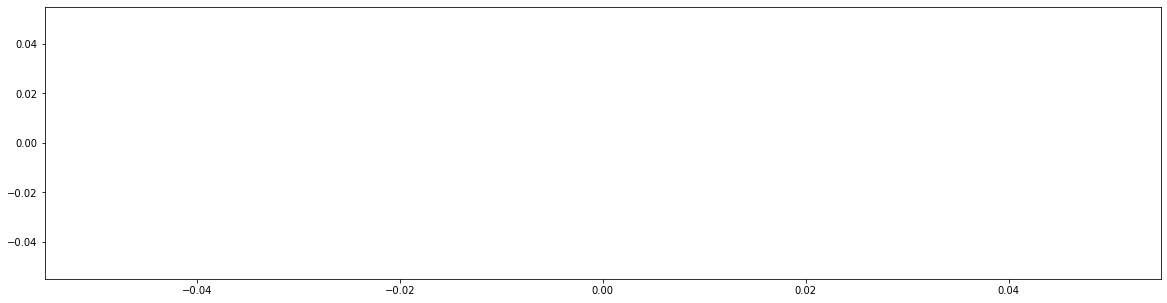

  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  0 | Reward:  -4072.533944112871 | Loss:  nan nan


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  1 | Reward:  -7760.831975736831 | Loss:  nan nan


/Users/anirudhasuhasdeshpande/Library/Python/3.8/lib/python/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1, 201, 1, 201, 1])) that is different to the input size (torch.Size([1, 201, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  2 | Reward:  -24531.366349799242 | Loss:  1841.4994 22.081278


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  3 | Reward:  -5577.534061273603 | Loss:  11517.969 74.907166


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  4 | Reward:  -876135.972715489 | Loss:  8703.992 97.10837


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  5 | Reward:  -1117300.580267914 | Loss:  11855189.0 261.18692


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  6 | Reward:  -887263.3289836367 | Loss:  24671518.0 566.46967


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  7 | Reward:  -1079648.302079662 | Loss:  28966836.0 636.211


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  8 | Reward:  -669300.1070009775 | Loss:  30399658.0 852.10974


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  9 | Reward:  -1149991.26610625 | Loss:  27738692.0 1175.3755


100%|██████████| 201/201 [14:09<00:00,  4.22s/it]


Plotting rewards now: and iteration  10


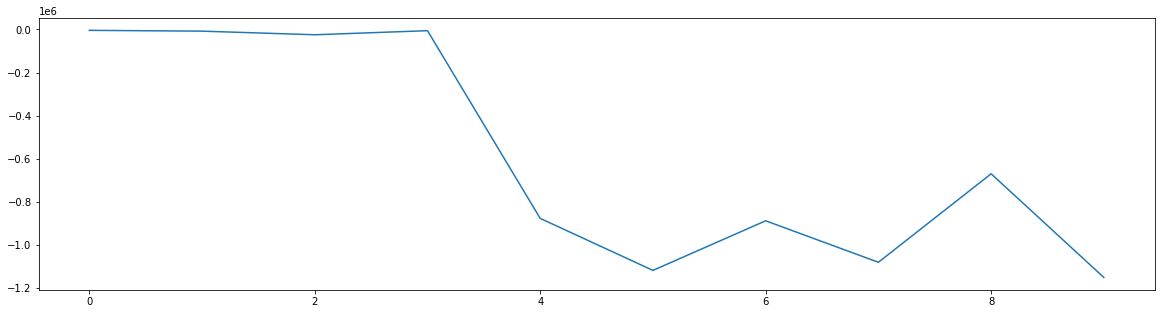

  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  10 | Reward:  -91576.8739385611 | Loss:  28995150.0 1519.2358


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  11 | Reward:  -244532.28938635497 | Loss:  26597564.0 1631.4176


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  12 | Reward:  -2690.1740429520837 | Loss:  24893344.0 1537.9689


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  13 | Reward:  -10244.097969844348 | Loss:  24253220.0 1702.3147


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  14 | Reward:  -6478.6961166767 | Loss:  20233678.0 1539.1816


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  15 | Reward:  -5935.115046329959 | Loss:  19504960.0 1548.1482


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  16 | Reward:  -4370.934461409753 | Loss:  17086214.0 1528.8038


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  17 | Reward:  -4824.294156181947 | Loss:  17959804.0 1464.58


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  18 | Reward:  -56509.177486965054 | Loss:  19041152.0 1620.536


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  19 | Reward:  -608.156039001744 | Loss:  16556783.0 1623.3108


100%|██████████| 201/201 [13:06<00:00,  3.91s/it]


Plotting rewards now: and iteration  20


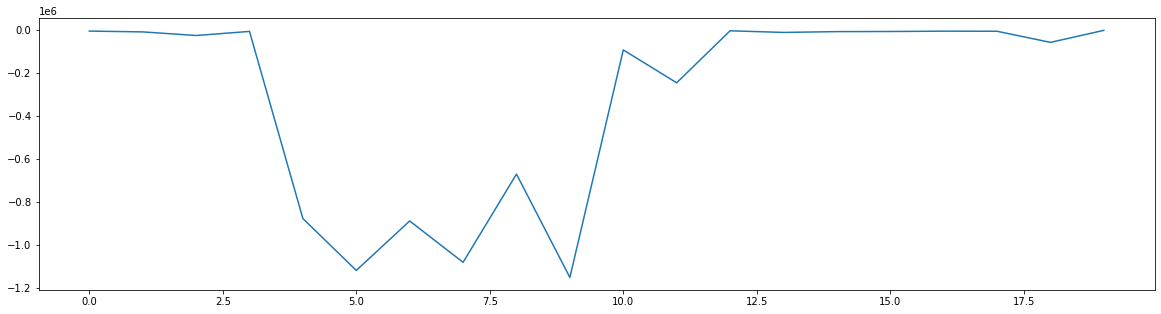

  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  20 | Reward:  -348.1634220791121 | Loss:  15578109.0 1608.0669


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  21 | Reward:  -499.6882914142759 | Loss:  12655784.0 1518.4141


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  22 | Reward:  -1242.9286103230652 | Loss:  13483981.0 1620.2858


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  23 | Reward:  -7335.194289696892 | Loss:  13704340.0 1520.0243


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  24 | Reward:  -706.3025943378987 | Loss:  11819455.0 1551.7988


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  25 | Reward:  -323.64474312961016 | Loss:  13385745.0 1618.3574


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  26 | Reward:  -1805.356463714364 | Loss:  9764043.0 1357.1038


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  27 | Reward:  -6277.609518297615 | Loss:  10598930.0 1552.492


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  28 | Reward:  -3968.2707133485997 | Loss:  8619941.0 1389.0625


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  29 | Reward:  -7324.327687489926 | Loss:  12451346.0 1682.1722


100%|██████████| 201/201 [13:55<00:00,  4.16s/it]


Plotting rewards now: and iteration  30


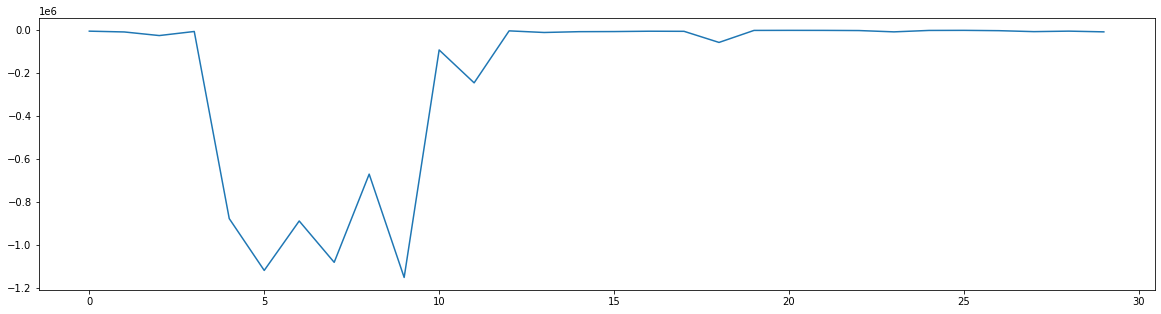

Eps:  30 | Reward:  -7097.739633586505 | Loss:  8653380.0 1434.3193


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  31 | Reward:  -6113.456492980501 | Loss:  7120456.5 1272.8579


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  32 | Reward:  -6353.701780900178 | Loss:  8936594.0 1408.4664


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  33 | Reward:  -4258.135084116254 | Loss:  8352872.5 1393.2013


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  34 | Reward:  -3443.70894776427 | Loss:  8360663.0 1427.5757


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  35 | Reward:  -11917.088427926163 | Loss:  7302447.0 1287.7123


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  36 | Reward:  -9356.664337017124 | Loss:  8746217.0 1506.3215


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  37 | Reward:  -926.4581856563676 | Loss:  7856725.5 1331.7233


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  38 | Reward:  -2287.6514817781963 | Loss:  8209797.5 1244.4337


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  39 | Reward:  -262.5511005584932 | Loss:  9311374.0 1507.6384


100%|██████████| 201/201 [13:57<00:00,  4.17s/it]


Plotting rewards now: and iteration  40


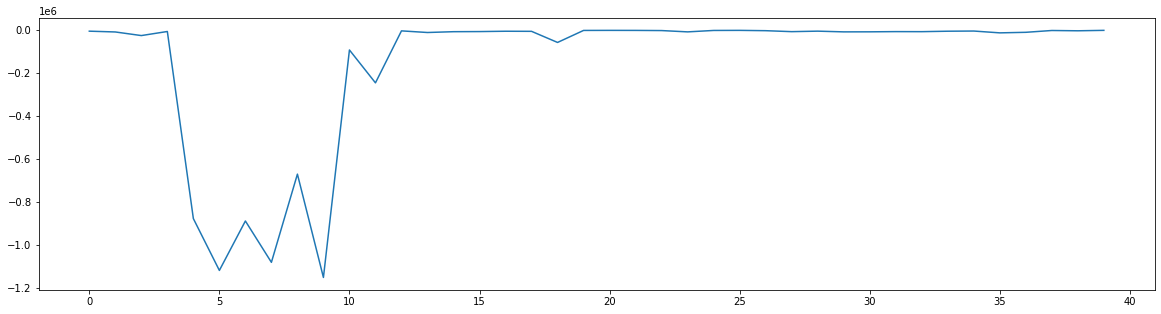

  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  40 | Reward:  -942.5474792275982 | Loss:  7325254.0 1415.9464


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  41 | Reward:  -1221.6438181159722 | Loss:  7446275.0 1373.7892


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  42 | Reward:  -1777.703271474117 | Loss:  8593077.0 1421.4729


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  43 | Reward:  -299.5526134703401 | Loss:  6531665.0 1304.4363


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  44 | Reward:  -953.2721690219767 | Loss:  6059750.5 1303.7864


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  45 | Reward:  -432.4749820510491 | Loss:  5641811.0 1201.0856


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  46 | Reward:  -1962.173206652485 | Loss:  6418111.0 1266.7368


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  47 | Reward:  -1520.312591461318 | Loss:  5771171.5 1210.6631


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  48 | Reward:  -2556.0953401581564 | Loss:  6839484.0 1298.398


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  49 | Reward:  -1737.819097076817 | Loss:  5883783.0 1008.2617


100%|██████████| 201/201 [13:44<00:00,  4.10s/it]


Plotting rewards now: and iteration  50


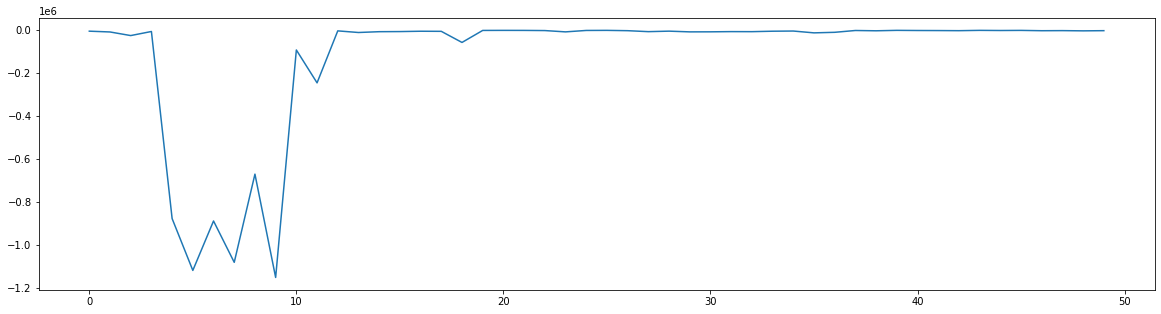

Eps:  50 | Reward:  -1013.8175254295475 | Loss:  6952922.0 1267.2366


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  51 | Reward:  -1262.8416106731422 | Loss:  5310374.0 900.09015


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  52 | Reward:  -1536.782591413796 | Loss:  5147922.0 1028.1831


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  53 | Reward:  -1047.941595737922 | Loss:  4154502.8 987.44806


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  54 | Reward:  -597.8689942709309 | Loss:  5790186.5 1149.5444


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  55 | Reward:  -1455.3651363355477 | Loss:  4658310.0 1028.9132


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  56 | Reward:  -634.8128772876452 | Loss:  5949865.5 1126.0566


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  57 | Reward:  -3354.4096776578476 | Loss:  5137652.0 899.27875


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  58 | Reward:  -2652.082642585916 | Loss:  5213724.0 797.15704


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  59 | Reward:  -1081.15216496866 | Loss:  4869437.0 828.90283


100%|██████████| 201/201 [13:49<00:00,  4.13s/it]


Plotting rewards now: and iteration  60


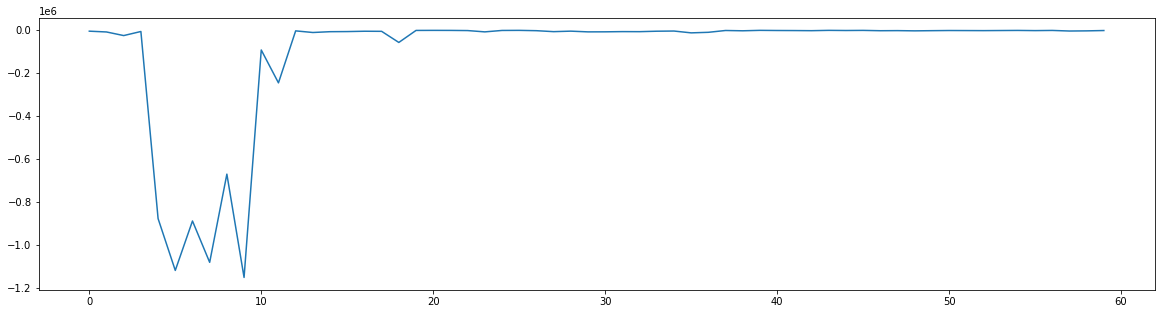

  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  60 | Reward:  -2398.3825525694547 | Loss:  3499074.8 647.7269


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  61 | Reward:  -10407.001325585907 | Loss:  5036463.0 714.1173


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  62 | Reward:  -5742.467434283229 | Loss:  5760930.0 810.86475


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  63 | Reward:  -5839.657731714079 | Loss:  3945737.2 632.69653


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  64 | Reward:  -8678.197511992843 | Loss:  4235354.5 578.5742


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  65 | Reward:  -11726.710808301003 | Loss:  3702669.0 645.0658


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  66 | Reward:  -26313.807395922522 | Loss:  4808422.0 670.45337


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  67 | Reward:  -2252.984103136416 | Loss:  3921758.2 609.5559


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  68 | Reward:  -902.8414231003711 | Loss:  4019283.5 608.1268


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  69 | Reward:  -458.82165275239896 | Loss:  4322627.5 594.9045


100%|██████████| 201/201 [13:47<00:00,  4.12s/it]


Plotting rewards now: and iteration  70


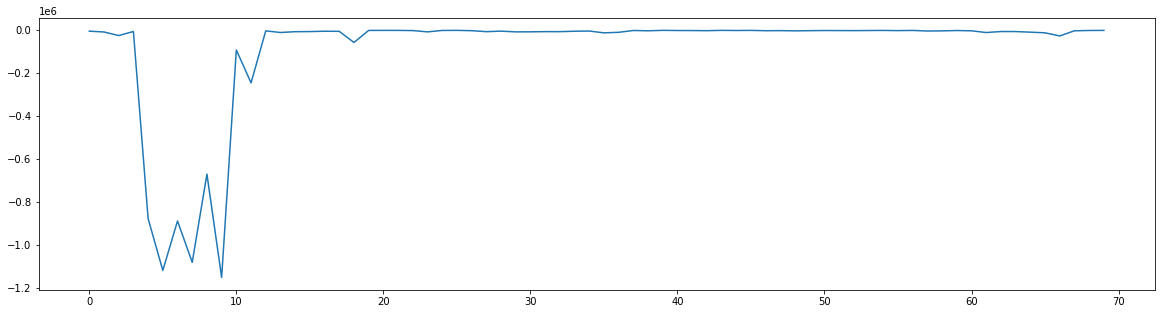

  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  70 | Reward:  -784.0330458985363 | Loss:  2330658.8 548.7975


  0%|          | 0/201 [00:00<?, ?it/s]

Eps:  71 | Reward:  -999.5589069388163 | Loss:  2288171.8 552.9414


 59%|█████▉    | 119/201 [17:31<11:58,  8.76s/it]

In [ ]:
max_episodes  = 100
max_steps   = 201
t_range = np.linspace(0,(max_steps-1)/100,max_steps) 

## Define 2 kinds of external distrubances to train on 
w_sin = 0.02*0.25*np.sin(t_range) 

w_step = np.zeros(t_range.shape)
w_step[t_range.shape[0]//4:(t_range.shape[0]//2)] = 0.02*0.25


frame_idx   = 0
rewards=[]

#for i_episode in tqdm(range(max_episodes)):
for i_episode in range(max_episodes):
    
    if (i_episode%2 == 0):
        w = w_sin
    else:
        w = w_step
    
    q_loss_list=[]
    policy_loss_list=[]
    
    #state = env.reset()
    
    state = np.concatenate((env.C@(env.reset()), np.atleast_2d(np.array([1e-6, 0])).T))[:,0]
    
    ## Add dimension to state so it can be fed properly into the neural net
    #state = state[None,:,:]
    #state = np.swapaxes(state,1,2)
    #state = torch.from_numpy(state)
    
    # print("HI", state.shape)
    
    episode_reward = 0
    last_action = env.action_space.sample()[:,0]
    episode_state = []
    episode_action = []
    episode_last_action = []
    episode_reward = []
    episode_next_state = []
    episode_done = []
    
    hidden_out = (torch.zeros([1, 1, hidden_dim], dtype=torch.float).to(device), \
        torch.zeros([1, 1, hidden_dim], dtype=torch.float).to(device))  # initialize hidden state for lstm, (hidden, cell), each is (layer, batch, dim)
    
    # hidden_out = (torch.zeros([1, 1, hidden_dim], dtype=torch.float), \
    #     torch.zeros([1, 1, hidden_dim], dtype=torch.float))  # initialize hidden state for lstm, (hidden, cell), each is (layer, batch, dim)    

    # for step in range(max_steps):
    for step in tqdm(range(max_steps)):
        hidden_in = hidden_out
        #print("H2I", state.shape)
        
        if (recurrent):
            action, hidden_out = alg.policy_net.get_action(state, last_action, hidden_in)
        
        else:
            action = alg.policy_net.get_action(state)
        
        #next_state, reward, done, _ = env.step(action)
        true_state, obs, cost, done, info = env.step(np.atleast_2d(action).astype(np.float32), meas_dist=np.atleast_2d(np.array([w[step] , 0])).T, t_step=step)
        next_state = np.concatenate((obs,np.atleast_2d(np.array([w[step] , 0])).T), 0)[:,0]
        reward = -cost
        #print("Next shape", next_state.shape)
        
        
        # if ENV !='Reacher':
        #     env.render()
        if step==0:
            ini_hidden_in = hidden_in
            ini_hidden_out = hidden_out
        episode_state.append(state)
        episode_action.append(action)
        episode_last_action.append(last_action)
        episode_reward.append(reward)
        episode_next_state.append(next_state)
        episode_done.append(done)  

        state = next_state
        last_action = action
        frame_idx += 1
        if len(replay_buffer) > batch_size:
            for _ in range(update_itr):
                q_loss, policy_loss = alg.update(batch_size)
                q_loss_list.append(q_loss)
                policy_loss_list.append(policy_loss)
            #print("UPDATED POLICY WITH BUFFER!")
        if done:  # should not break for lstm cases to make every episode with same length
            break        

    if i_episode % 10 == 0:
        print("Plotting rewards now: and iteration ", i_episode)
        plot(rewards)
        alg.save_model(model_path)
    print('Eps: ', i_episode, '| Reward: ', np.sum(episode_reward), '| Loss: ', np.average(q_loss_list), np.average(policy_loss_list))
    replay_buffer.push(ini_hidden_in, ini_hidden_out, episode_state, episode_action, episode_last_action, \
        episode_reward, episode_next_state, episode_done)

    rewards.append(np.sum(episode_reward))
    alg.save_model(model_path)

In [ ]:
alg.update(batch_size)

In [ ]:
np.concatenate((env.C@(env.reset()), np.atleast_2d(np.array([1e-6, 0])).T))

In [ ]:
t_range = np.linspace(0,40,4001) 

w_step = np.zeros(t_range.shape)
w_step[t_range.shape[0]//4:(t_range.shape[0]//2)] = 0.02*0.25

In [ ]:
plt.figure()
plt.plot(w_step)

In [ ]:
state = state[None,:,:]
state = np.swapaxes(state,1,2)

In [ ]:
state.shape

In [ ]:
state.permute(1,0,2)

In [ ]:
torch.from_numpy(state).permute(1,0,2).shape

In [ ]:
state = torch.FloatTensor(state).unsqueeze(0).unsqueeze(0)

In [ ]:
state.shape

In [ ]:
last_action.shape